# Robust models

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng(123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# A second, *robust* linear model

Our first linear model
was motivated by the probability model
$$\begin{aligned}
    y_i &= x_i \cdot \beta + \epsilon_i \\
    \epsilon_i &\sim \text{Normal}(\text{mean}=0, \text{sd}=\sigma) ,
\end{aligned}$$
which led us to choosing $\beta$ by minimizing the sum of squared errors,
$$ \sum_i (y_i - x_i \cdot \beta)^2 . $$

A natural question is: how much do the results depend on the "distributional assumptions",
i.e., the "Normal( )"?

## The Cauchy

The Cauchy distribution is another probability distribution:
it can take any value (like the Normal),
its histogram looks like a hump (like the Normal),
and it has both "location" and "scale" parameters (like the Normal).
Let's have a look at the model
$$\begin{aligned}
    y_i &= x_i \cdot \beta + \epsilon_i \\
    \epsilon_i &\sim \text{Cauchy}(\text{loc}=0, \text{scale}=\sigma) .
\end{aligned}$$

First we'll simulate from the model
and see how well doing the usual method works.

In [2]:
n = 200
k = 2
x = rng.uniform(size=(n, k))
beta = [10, -2]
y = x.dot(beta) + rng.standard_cauchy(size=n)
print(f"max(y)={np.max(y):.1f}; min(y)={np.min(y):.1f}")

max(y)=633.0; min(y)=-90.6


A plot of `y` against `x0` and `x1` shows only slight trends,
because the $y$ axes are huge; most of the points are near zero.

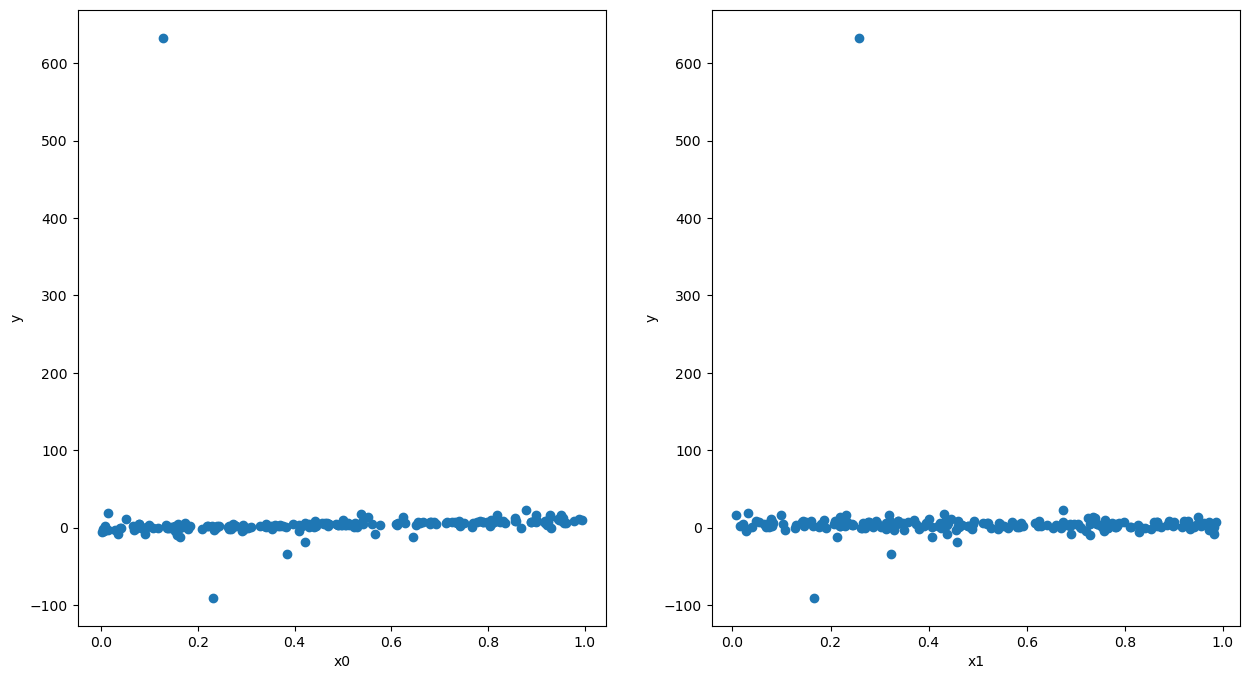

In [3]:
# plot 1
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x[:,0], y); ax1.set_xlabel(f"x0"); ax1.set_ylabel("y")
ax2.scatter(x[:,1], y); ax2.set_xlabel(f"x1"); ax2.set_ylabel("y");

If we zoom in the $y$ axis we can see what's going on
(omitting the outliers):

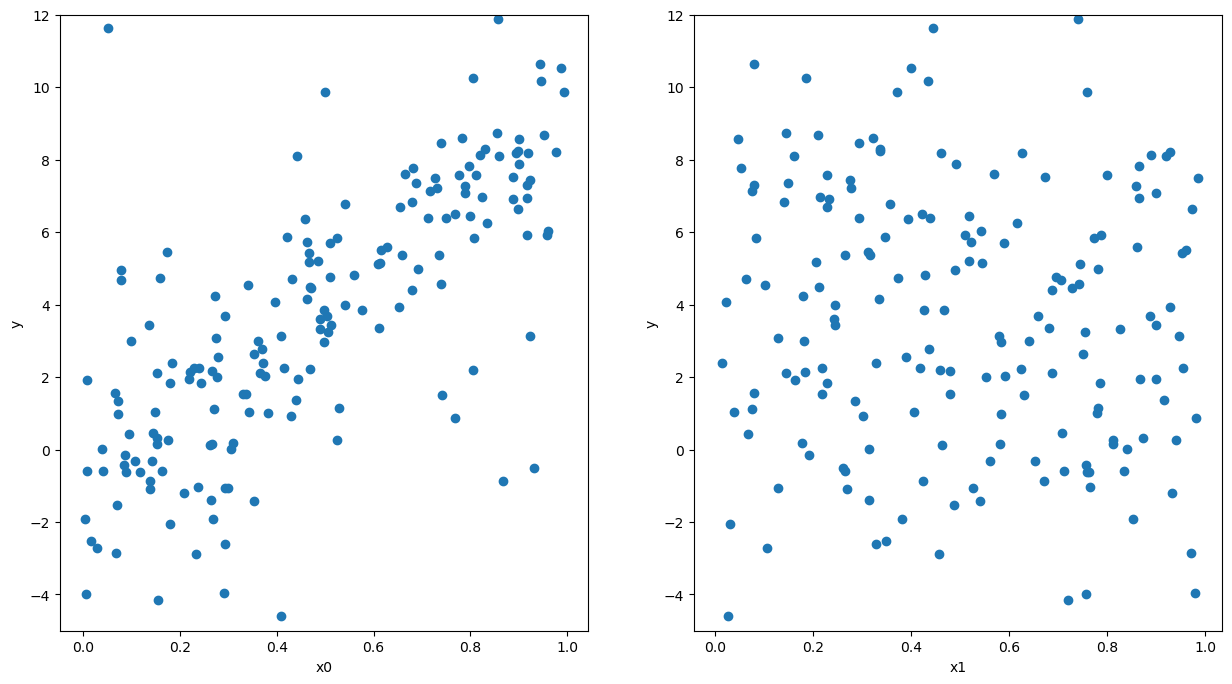

In [4]:
# Plot 2
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(x[:,0], y); ax1.set_xlabel(f"x0"); ax1.set_ylabel("y"); ax1.set_ylim((-5, 12))
ax2.scatter(x[:,1], y); ax2.set_xlabel(f"x1"); ax2.set_ylabel("y"); ax2.set_ylim((-5, 12));

In [5]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression(fit_intercept=True)
line_reg.fit(x, y)
y_hat = line_reg.predict(x)

print(f"Estimated beta0={line_reg.coef_[0]:.2f}; beta1={line_reg.coef_[1]:.2f}")

Estimated beta0=0.05; beta1=-9.46


In [6]:
resids = y - y_hat
print(f"residuals: min={min(resids):.1f}, 5%ile={np.quantile(resids, 0.05):.1f}", 
      f"median={np.mean(resids):.1f}, mean={np.mean(resids):.1f}, "
      f"95%ile={np.quantile(resids, 0.95):.1f}, max={max(resids):.1f}")

residuals: min=-99.9, 5%ile=-12.6 median=0.0, mean=0.0, 95%ile=6.4, max=624.6


The plot of predicted (`y_hat`) versus observed (`y`)
shows a line going upwards through a broadly scattered set of points
-- *not* a very tight relationship.

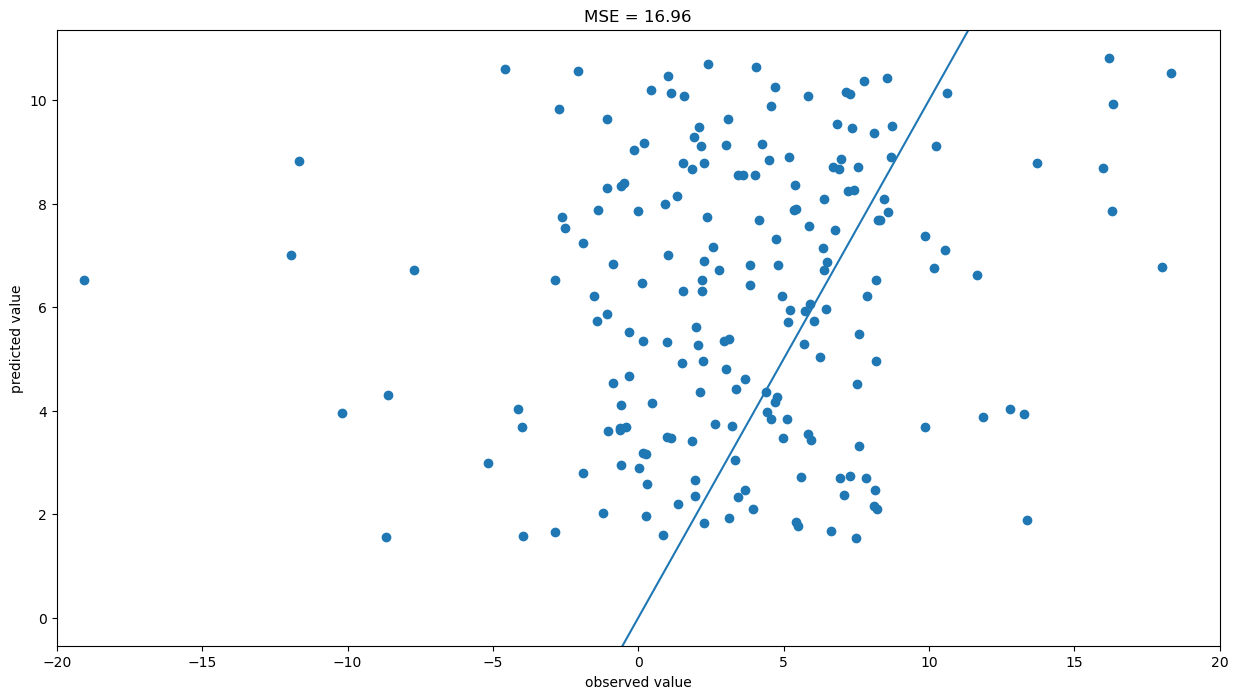

In [7]:
# plot 3
fig, ax = plt.subplots()
ax.scatter(y, y_hat)
ax.set_xlim(-20, 20)
ax.set_xlabel("observed value")
ax.set_ylabel("predicted value")
ax.set_title(f"MSE = {np.median((y - y_hat)**2):.2f}")
ax.axline((0,0), slope=1);

What to do?
Well, the [Cauchy density](https://en.wikipedia.org/wiki/Cauchy_distribution) with scale $\sigma$ is
$$
    f(u) = \frac{1}{\pi \sigma \left(1 + (u / \sigma)^2\right)} .
$$

So, the likelihood of the data are
$$ \prod_{i=1}^n f(y_i - \hat y_i) , $$
and so the log-likelihood, with $\hat y_i = x_i \beta$,
is 
$$    - \sum_{i=1}^n \log\left( 1 + ((y_i - x_i \beta) / \sigma)^2 \right) - n \log(\pi \sigma) . $$

In [8]:
from scipy.optimize import minimize

def logl(u): # negative log-likelihood
    beta = u[:-1]
    sigma = u[-1]
    yhat = x.dot(beta)
    return np.sum(np.log(1 + ((y - yhat) / sigma)**2)) + n * np.log(np.pi * sigma)

res = minimize(logl, [1, 1, 1])
est_beta = res['x'][:-1]
est_sigma = res['x'][-1]
new_yhat = x.dot(est_beta)
print(f"Estimated beta0={est_beta[0]:.2f}; beta1={est_beta[1]:.2f}")

Estimated beta0=10.37; beta1=-2.47


Now the predicted versus observed plot looks *much* better:
a fairly tight cluster of points around the line, but with some further away values.

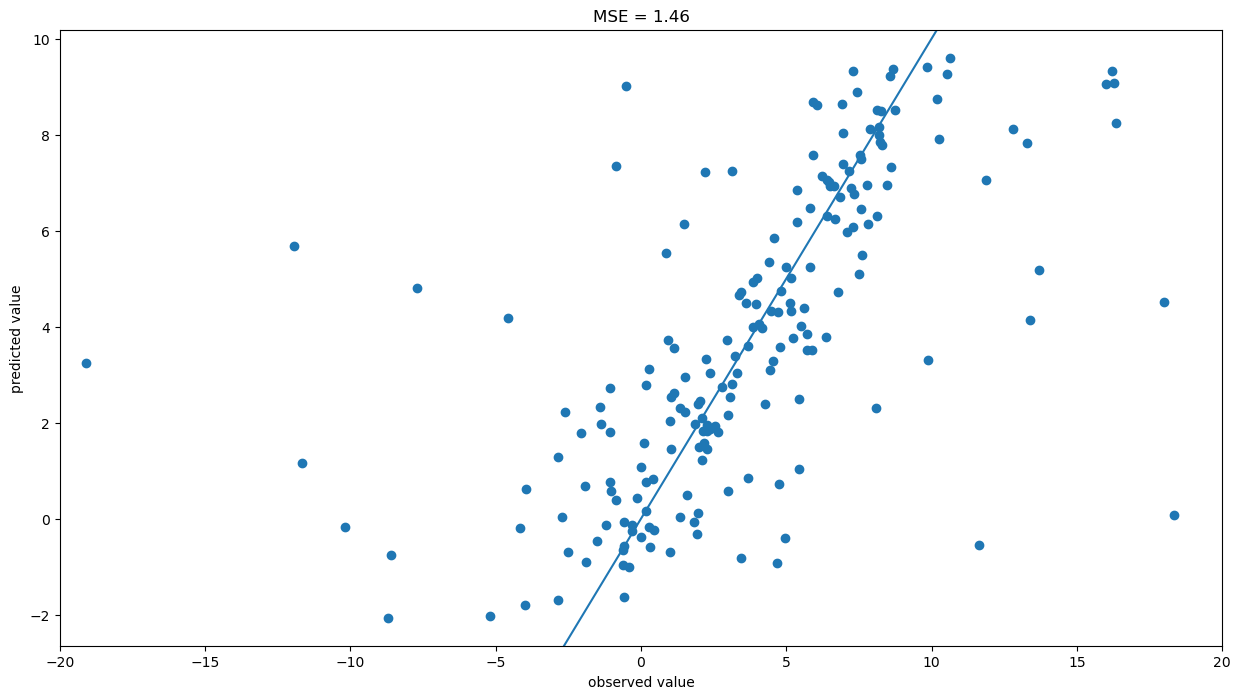

In [9]:

fig, ax = plt.subplots()
ax.scatter(y, new_yhat)
ax.set_xlim(-20, 20)
ax.set_xlabel("observed value")
ax.set_ylabel("predicted value")
ax.set_title(f"MSE = {np.median((y - new_yhat)**2):.2f}")
ax.axline((0,0), slope=1);

## What did we do there?

We adjusted the *loss function*:
a more general way of describing what we're doing
is that we're trying to minimize the *loss*
$$ \sum_i L(y_i - \hat y_i), $$
where $L( )$ is a function that quantifies how "bad" an "error" of a given size is.

The standard linear model used $L(u) = u^2$;
the Cauchy model led us to use
$$ L(u) = \log(1 + u^2) . $$

What's the difference?  Well, the PDFs of the two both look like bumps,
but the Cauchy's goes to zero slower:

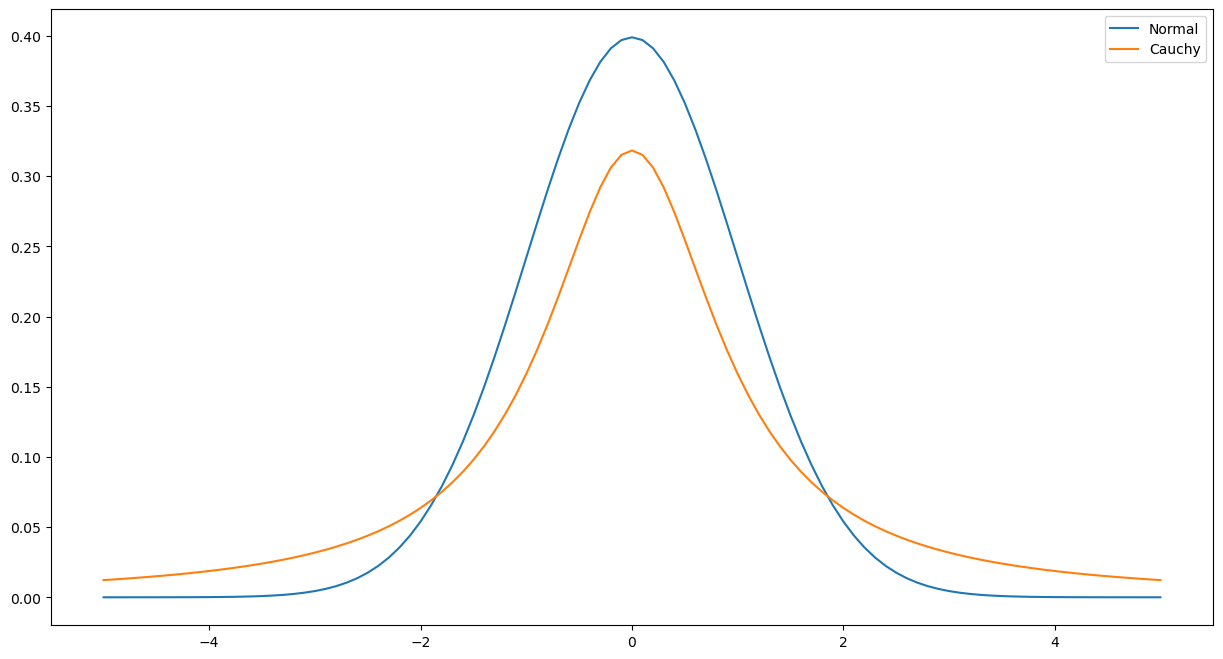

In [10]:
from scipy.stats import norm, cauchy
fig, ax = plt.subplots()
xvals = np.linspace(-5, 5, 101)
ax.plot(xvals, norm.pdf(xvals), label='Normal')
ax.plot(xvals, cauchy.pdf(xvals), label='Cauchy')
ax.legend();

Those don't look *too* different.
But have a look at the (negative) *log* PDF
(which is what we use for a loss function):
the Normal is a quadratic, but the Cauchy goes up only gradually (like log()).

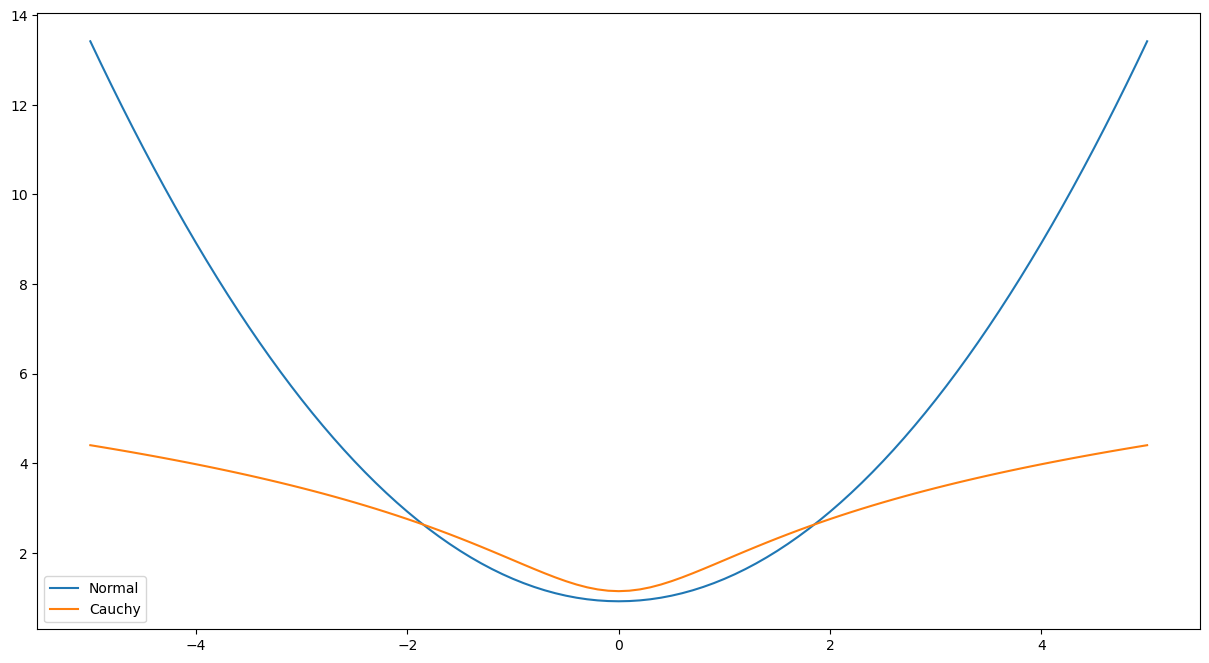

In [11]:
from scipy.stats import norm, cauchy
fig, ax = plt.subplots()
xvals = np.linspace(-5, 5, 101)
ax.plot(xvals, -1 * norm.logpdf(xvals), label='Normal')
ax.plot(xvals, -1 * cauchy.logpdf(xvals), label='Cauchy')
ax.legend();